# dacon_마케팅_info_EDA

- 마케팅 정보 데이터에 대한 시계열 분석입니다.

---

# 목차
- import
- read data
- 시도표 확인
- 분산안정화
- ACF, PACF
- 모형적합

---

# import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import*
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.formula.api import *
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import*
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


# 한글깨짐해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

---

# read data

In [2]:
df = pd.read_csv('C:\\Users\\minu\\lab\\dacon0210\\Marketing_info.csv')
df = df.set_index('날짜')
df.head()

,오프라인비용,온라인비용
날짜,,
2019-01-01,4500,2424.50
2019-01-02,4500,3480.36
2019-01-03,4500,1576.38
2019-01-04,4500,2928.55
2019-01-05,4500,4055.30


In [3]:
df.columns

Index(['오프라인비용', '온라인비용'], dtype='object')

In [4]:
df.shape

(365, 2)

In [5]:
df.isnull().sum(axis=0)

오프라인비용    0
온라인비용     0
dtype: int64

- 데이터 정보
    - 칼럼은 3개
        - 날짜, 오프라인비용, 온라인비용
    - shape : 365*3
    - 결측치 없음

- 데이터 변수
    - 날짜 : 시계열 데이터
    - 비용 데이터 : 연속형 데이터
    - 날짜는 데이터프레임에 인덱스로 포함하도록 하겠음
    
- 날짜 : 마케팅이 이루어진 날짜
- 오프라인비용 : 오프라인 마케팅으로 지출한 비용 (단위 : 달러)
- 온라인비용 : 온라인 마케팅으로 지출한 비용 (단위 : 달러)

---

# 시도표 확인

In [6]:
mean_off = df['오프라인비용'].mean()
mean_on =df['온라인비용'].mean()

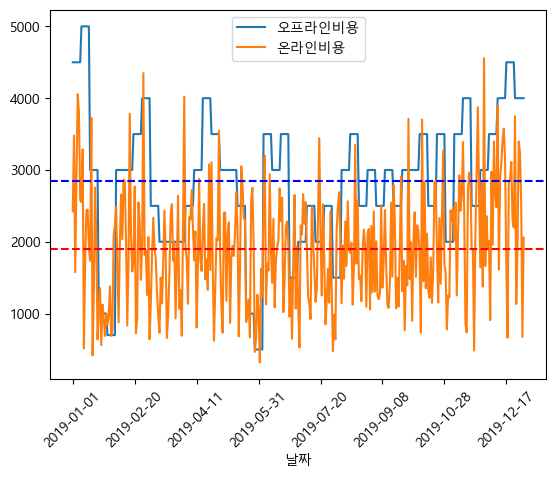

In [7]:
df.plot();
plt.xticks(rotation=45)
plt.axhline(y=mean_off, color='b', linestyle='--')
plt.axhline(y=mean_on, color='r', linestyle='--')
plt.show()
# plt.set_xticks(np.arange(0,len(df.index)+1,10))

- 마케팅 비용의 오프라인, 온라인 비용의 시도표이다
    - 오프라인 비용이 전반적으로 높은 수준을 지닌 것을 알 수 있음
    - 오프리인 비용은 한번 결정이되면 어느 기간동안 유지되는 것을 알 수 있음
    - 온라인 비용은 비용 변동이 훨씬 크다
    - 이 둘은 비슷한 추세를 따라가는 것으로 보이나, 서로 수준은 달라보인다
    - 각 수평의 파랑, 빨강선은 평균을 의미함, 큰 차이로 벌어져있다.
- 정상시계열 판단
    - 오프라인비용은 어떤 특정값을 유지하는 경향이 있어 정상성을 띄기 어려울 것으로 보인다
    - 온라인비용은 평균에 크게 벗어나지 않고 시도표만으로 비정상 시계열처럼 보이진 않는다.

---

# 분산안정화

- ARIMA 모형을 적합하여 시계열 데이터의 성분을 파악해보려고 한다.
- 따라서 해당 데이터의 분산을 우선적으로 안정화하는 작업이 필요 
- Breusch-Pagan Test
    - H0 : data가 등분산이다
    - H1 : 등분산이 아니다

In [9]:
# boxcox 변환
#value1, c1 = boxcox(df['오프라인비용'].values)
#value2, c2 = boxcox(df['온라인비용'].values)
t = np.arange(len(df))

df3 = np.log(df)
df['t'] = t
df3['t'] = t

In [10]:

m1 = ols('오프라인비용 ~t',data=df3).fit()
m2 = ols('오프라인비용~t',data=df).fit()
m3 = ols('온라인비용 ~t',data=df3).fit()
m4 = ols('온라인비용~t',data=df).fit()

In [11]:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
test_result = sms.het_breuschpagan(m1.resid, m1.model.exog)
test_result2 = sms.het_breuschpagan(m2.resid, m2.model.exog)
test_result3 = sms.het_breuschpagan(m3.resid, m3.model.exog)
test_result4 = sms.het_breuschpagan(m4.resid, m4.model.exog)


print('오프라인 변환o',test_result[1])
print('오프라인 변환x',test_result2[1])
print('온라인 변환o',test_result3[1])
print('온라인 변환x',test_result4[1])


오프라인 변환o 9.912206603816862e-08
오프라인 변환x 3.906246300317428e-11
온라인 변환o 0.053192390208536625
온라인 변환x 0.5541045010779346


- 오프라인비용은 모든 결과가 유의하지만 그나마 로그변환이 p-value가 더 크게 나왔기 때문에 로그변환 진행
- 온라인비용은 로그변환을 하지 않았을 때, 영가설을 기각하지 못하므로 변환하지 않겠다.

---

# acf, pacf 도표

## 오프라인 비용 성분파악

In [12]:
date_range = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D')

on_cost = pd.Series(df['온라인비용'].values,index=date_range)
off_cost = pd.Series(df3['오프라인비용'].values,index=date_range)

C:\Users\minu\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


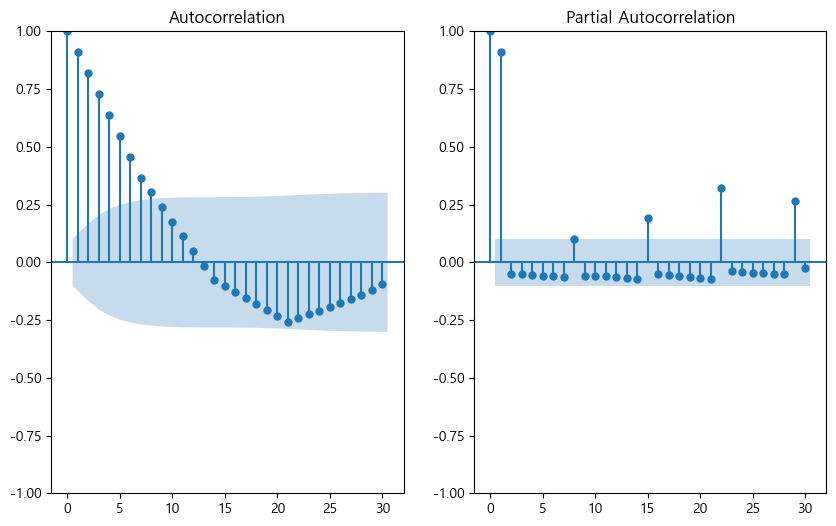

In [43]:
%matplotlib inline

fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(off_cost, lags=30, ax=ax[0]);
plot_pacf(off_cost, lags=30, ax=ax[1]);

- 오프라인 비용에 대한 ACF, PACF 도표이다
    - ACF, PACF 도표를 통해 기각역에 크게벗어나는 것을 확인 비정상 시계열이다.
    - ACF 도표를 통해 천천히 감소하는 양상을 확인할 수 있어 추세 차분이 필요로 해보인다
    - PACF 도표를 통해 특정 주기마다 기각역을 벗어나는 양상을 보인다. 계절 차분을 진행하려고 함
    - 또한 PACF 2번째까지 기각역을 벗어난뒤 절단이라 AR 모형이 고려할만하다

### 추세 차분

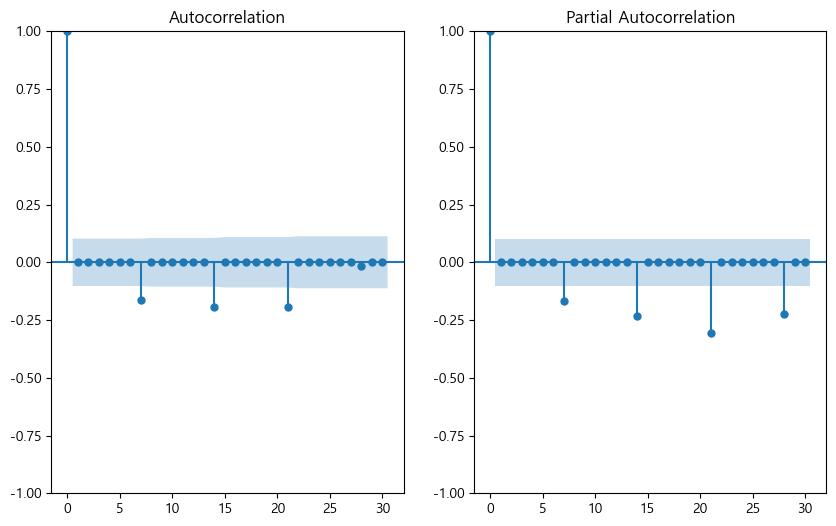

In [14]:
off_cost_diff = off_cost.diff(1).dropna(axis=0)
fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(off_cost_diff, lags=30, ax=ax[0]);
plot_pacf(off_cost_diff, lags=30, ax=ax[1]);

- 추세를 차분한 ACF, PACF의 도표이다
    - ACF의 도표를 통해 추세성분이 제거되었다. 하지만 일정 주기마다 기각역을 벗어나는 
    경우가 있음
    - PACF 또한 ACF의 같은 주기마다 기각역을 벗어남
    - 계절성이 존재한다.

### 계절차분

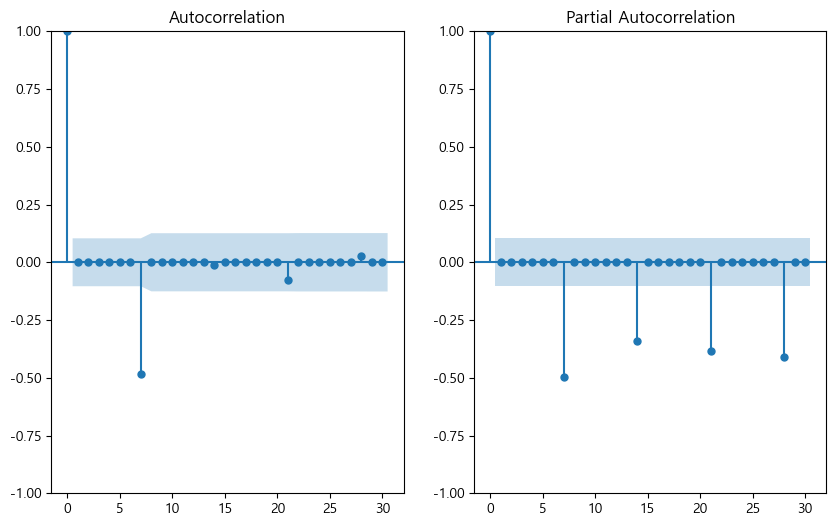

In [15]:
off_cost_diff7 = off_cost.diff(1).diff(7).dropna(axis=0)

fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(off_cost_diff7, lags=30, ax=ax[0]);
plot_pacf(off_cost_diff7, lags=30, ax=ax[1]);

- 계절차분을 진행한 ACF. PACF 도표이다.
    - 시계열 데이터가 day로 기록되어 있기 때문에 일주일 단위인 7로 계절 차분을 진행하였다.
    - ACF에서 2번째로 기각역에 벗어난 시차를 제외하고 나머지가 기각역에 들어갔으며
    - PACF는 아직 주기성이 존재함으로 계절형 SMA모형이 고려된다

---

## 온라인비용 성분파악

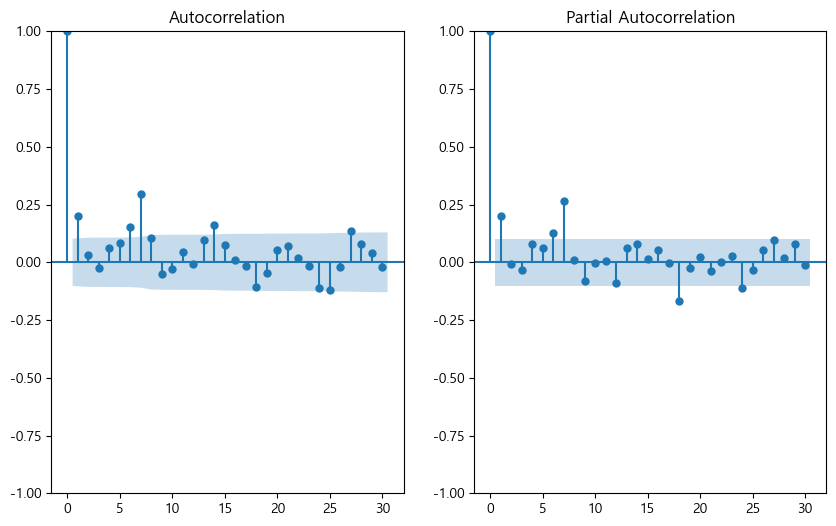

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(on_cost, lags=30, ax=ax[0]);
plot_pacf(on_cost, lags=30, ax=ax[1]);

- 온라인비용에 대한 ACF, PACF 모형이다. 
- 대부분의 시차가 기각역에 들어가 있지만 특정 시차가 튀어나와있다.
- 추세성분은 시도표 및 ACF에서도 보이지 않으니 차분은 하지 않고 계절차분만 진행해보려한다.
- 계절차분이 성공적이지 않으면 바로 모형을 적합해볼만하다. ACF와 PACF 1차시 이후 크게 절단이 되어있으므로 ARMA(1,1)모형이 고려되어진다.

###  차분 단위근 검정

- 차분이 필요한지 단위근 검정을 통해 알아보려한다
    - H0 : 단위근이 존재한다
    - H1 : 단위근이 존재하지 않는다

In [78]:
result = adfuller(on_cost,regression = 'n')
print('영가설을 기각할까?', 'No' if result[1] > 0.05 else 'Yes')
#print('ADF Statistic:', result[0])
print('p-value:', result[1])
#print('Critical Values:', result[4])


영가설을 기각할까? No
p-value: 0.5281497373729626


- 영가설을 기각하지 못했으므로 단위근은 존재한다. 추세차분을 진행하고 정상시계열이 아님을 보이는 증거를 얻었다

### 정상성 검정

- H0 : 정상성 시계열
- H1 : not 정상 시계열

In [85]:
result = kpss(on_cost)
print('영가설을 기각할까?', 'No' if result[1] > 0.05 else 'Yes')
print('p-value:', result[1])      

영가설을 기각할까? Yes
p-value: 0.01


C:\Users\minu\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


- 영가설을 기각하므로 대립가설 채택, 정상시계열이 아님을 보여주는 증거를 얻었다

### 계절차분

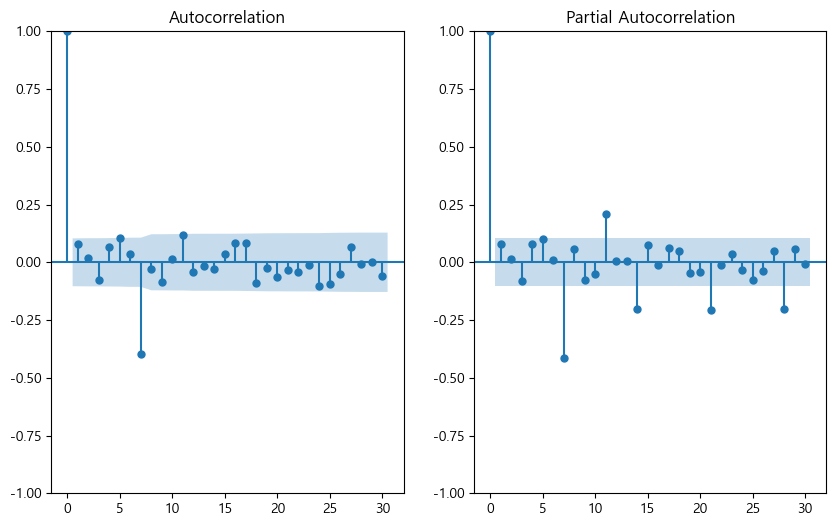

In [17]:
on_cost_diff7 = on_cost.diff(7).dropna(axis=0)
fig, ax = plt.subplots(1,2,figsize=(10, 6))
plot_acf(on_cost_diff7, lags=30, ax=ax[0]);
plot_pacf(on_cost_diff7, lags=30, ax=ax[1]);

- 온라인비용에 대한 계절차분을 진행한 도표이다
    - 마찬가지로 주기를 7로 계절성분을 차분하였다.
    - ACF의 대다수의 시차가 기각역에 포함되었지만 PACF는 계절성이 두드러지게 나타난다.
    - 이는 계절차분을 진행할 것인지에 대해 선택사항인데 모형의 단순함을 위해 계절차분은 진행
    않도록한다

---

# 정리

- 오프라인 비용은 추세차분과 계절차분 진행, 그리고 SMA(1)모형을 적합
$$
(1-B)(1-\Theta_1 B^7)(Zt-\mu) = \epsilon_t
$$


- 온라인 비용은 차분없이 ARIMA(1,0,1) 모형을 우선 적합
$$
(1-\phi_1 B)(1-B)(Zt-\mu) = (1-\theta_1 B)\epsilon_t
$$


---

# 모형적합

`-` **알림**
- 모형적합하고 예측이 주된 것이 아니고 데이터에 대한 성분을 파악하기 위함
- 잔차분석과 다른 모형과의 비교는 생략하도록 하겠다

### 오프라인 비용 data 

In [18]:
order = (0, 1, 0) 
seasonal_order = (0, 0, 1, 7)  
m1 = ARIMA(off_cost,order = order,seasonal_order=seasonal_order)
m1_fit= m1.fit()
m1_fit.summary()
#simulated_data = m1_fit.simulate(nsimulations=365)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  365
Model:             ARIMA(0, 1, 0)x(0, 0, [1], 7)   Log Likelihood                 121.719
Date:                           Sun, 11 Feb 2024   AIC                           -239.439
Time:                                   17:38:36   BIC                           -231.644
Sample:                               01-01-2019   HQIC                          -236.341
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8871      0.015    -59.997      0.000      -0.916      -0.858
sigma2         0.0291      0.000     62.293      0.000       0.028       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26665.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -4.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
m1pred = m1_fit.predict(start = '2019-01-01',end = '2019-12-31', typ='levels')

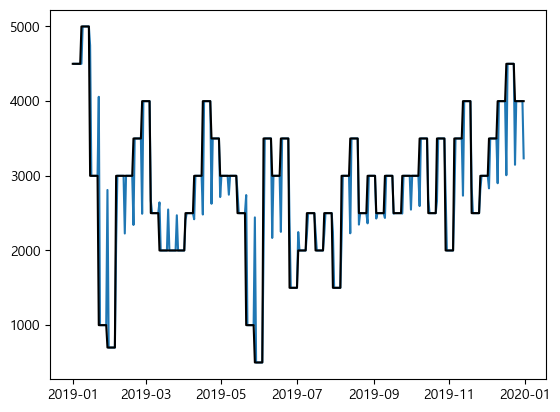

In [20]:
plt.plot(np.exp(m1pred[1:]))
plt.plot(np.exp(off_cost),color = 'black')

- fitted data를 이용해 다시 predict를 한 것으로 얼마나 모형이 적합이 잘되었는지 보여준다.
- 실제 observed data와는 달리 주기성이 더 강하게 예측이 되었다.
- 하지만 전반적인 데이터의 형태는 정확히 따라가고 있음

---

### 온라인 비용

In [68]:
order = (1, 1, 1) 
#seasonal_order = (0, 0, 0)  
m2 = ARIMA(on_cost,order = order)
m2_fit= m2.fit()
m2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2944.708
Date:                Sun, 11 Feb 2024   AIC                           5895.416
Time:                        17:59:46   BIC                           5907.107
Sample:                    01-01-2019   HQIC                          5900.063
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1455      0.060      2.425      0.015       0.028       0.263
ma.L1         -0.9667      0.015    -64.970      0.000      -0.996      -0.938
sigma2      6.188e+05   4.46e+04     13.877      0.000    5.31e+05    7.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.95
Prob(Q):                              0.95   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.25
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

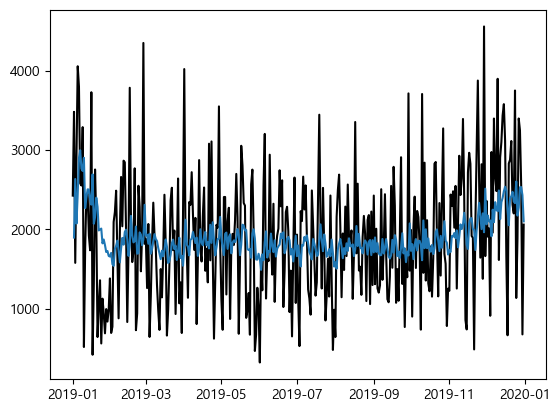

In [66]:
m2pred = m2_fit.predict(start = '2019-01-01',end = '2019-12-31', typ='levels')

plt.plot(on_cost,color = 'black')
plt.plot(m2pred[1:])

- 실제 observed data는 분산이 매우 큰 것으로 보인다.
- predict 결과는 평균을 따라 소극적으로 예측된 것을 확인할 수 있다
- 분산이 크다는 것은 움직이는 영역이 넓다는 의미로 보면 된다.
    - 즉 온라인 비용의 가격 변동이 영역이 매우 크다.
    - 유지하고자하는 성질이 적으며, 이것은 domain에 대한 어떤 영향이 큰 것으로 보임